In [1]:
import statsmodels.api as sm

data = sm.datasets.co2.load_pandas()
co2 = data.data
print(co2.info())
print(co2.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB
None
              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4


5


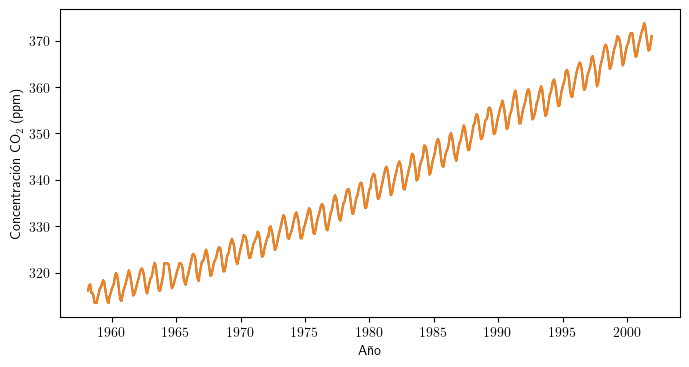

In [2]:
import matplotlib.pyplot as plt

y = co2['co2'].resample('MS').mean()
print(y.isnull().sum())
y = y.bfill()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(y)
plt.xlabel('Año')
plt.ylabel('Concentración CO$_2$ (ppm)')
plt.plot(y)

In [3]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(values): 
    dftest = adfuller(values, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    mensaje = "\t{}: {} - Los datos {} estacionarios con {}% de confianza"
    for k, v in dftest[4].items():
        print(mensaje.format(k, v, "no son" if v<dftest[0] else "son", 100-int(k[:-1])))

In [4]:
check_stationary(y)

Test statistic = 2.360
P-value = 0.999
Critical values :
	1%: -3.4432119442564324 - Los datos no son estacionarios con 99% de confianza
	5%: -2.8672126791646955 - Los datos no son estacionarios con 95% de confianza
	10%: -2.569791324979607 - Los datos no son estacionarios con 90% de confianza


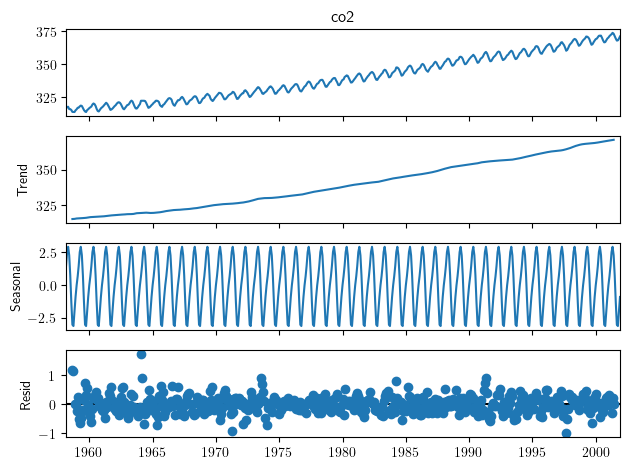

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(y, model='additive', period=12)
result.plot();

In [6]:
check_stationary(result.seasonal)

Test statistic = -43337046870601.086
P-value = 0.000
Critical values :
	1%: -3.4432119442564324 - Los datos son estacionarios con 99% de confianza
	5%: -2.8672126791646955 - Los datos son estacionarios con 95% de confianza
	10%: -2.569791324979607 - Los datos son estacionarios con 90% de confianza


Test statistic = -5.063
P-value = 0.000
Critical values :
	1%: -3.4432119442564324 - Los datos son estacionarios con 99% de confianza
	5%: -2.8672126791646955 - Los datos son estacionarios con 95% de confianza
	10%: -2.569791324979607 - Los datos son estacionarios con 90% de confianza


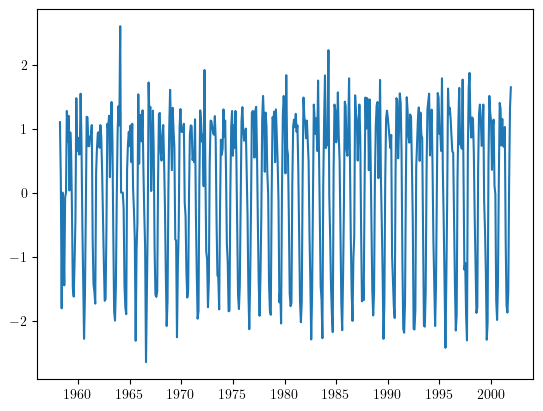

In [7]:
y_1 = y.diff()
check_stationary(y_1[1:])
plt.plot(y_1)

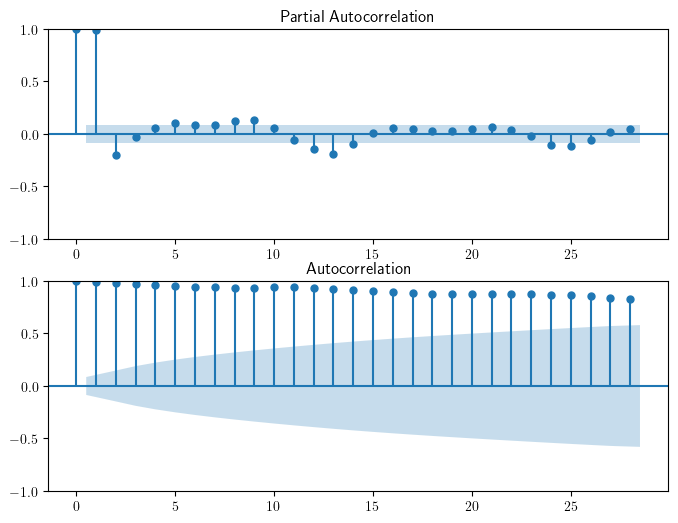

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_pacf(y, method='ywm', ax=ax1);
plot_acf(y, ax=ax2);

In [9]:
n_train = int(0.85 * y.size)
n_samples = y.size
n_valid = n_samples - n_train
y_train, y_valid = y[:n_train], y[n_train:]
print(f'Número de muestras: {n_samples}, entrenamiento: {n_train}, validación: {n_valid}')

Número de muestras: 526, entrenamiento: 447, validación: 79


In [10]:
import itertools
import warnings
from statsmodels.tsa.api import SARIMAX

warnings.filterwarnings("ignore")

p = d = q = range(0, 3)
# (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), ...
pdq = itertools.product(p, d, q)
# (0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), ...
seasonal_PDQ = itertools.product(p, d, q, [12])

model_evals = []
for param in pdq:
    for param_seasonal in seasonal_PDQ:
        mod = SARIMAX(
            y_train, order=param, seasonal_order=param_seasonal,
            enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit(disp=0)
        model_evals.append([param, param_seasonal, results.aic, results.bic])

In [11]:
for param, param_seasonal, aic, bic in model_evals:
    if aic < 900 or bic < 900:
        print(f"AIC: {aic}, BIC: {bic}, (p, d, q)={param}, (P, D, Q, 12)={param_seasonal}")

AIC: 850.0800066715967, BIC: 858.1123209909935, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(0, 2, 1, 12)
AIC: 806.9674764810895, BIC: 818.9268324969429, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(0, 2, 2, 12)
AIC: 859.3854459797975, BIC: 867.5361380419748, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 0, 0, 12)
AIC: 858.2005034043332, BIC: 870.4196370066344, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 0, 1, 12)
AIC: 831.1939496722154, BIC: 847.3739709283594, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 0, 2, 12)
AIC: 856.4371945906423, BIC: 868.5722105327503, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 1, 1, 12)
AIC: 823.7388931519195, BIC: 839.8035217907129, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 1, 2, 12)
AIC: 841.9230576997115, BIC: 853.9715291788066, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 2, 1, 12)
AIC: 807.7313884905143, BIC: 823.677196511652, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(1, 2, 2, 12)
AIC: 831.4336726656362, BIC: 843.575789202775, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(2, 0, 0, 12)
AIC: 832.8510525948286, BIC: 849

In [12]:
model = SARIMAX(
    y_train, order=(0, 0, 0), seasonal_order=(2, 2, 1, 12),
    enforce_stationarity=True, enforce_invertibility=False)
model_fit = model.fit(disp=0, maxiter=200)
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:                        co2   No. Observations:                  447
Model:             SARIMAX(2, 2, [1], 12)   Log Likelihood                -423.255
Date:                    lun, 14 oct 2024   AIC                            854.511
Time:                            22:51:54   BIC                            870.700
Sample:                        03-01-1958   HQIC                           860.908
                             - 05-01-1995                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2795      0.067     -4.172      0.000      -0.411      -0.148
ar.S.L24      -0.2458      0.064     -3.835      0.000      -0.371      -0.120
ma.S.L12      -0.749

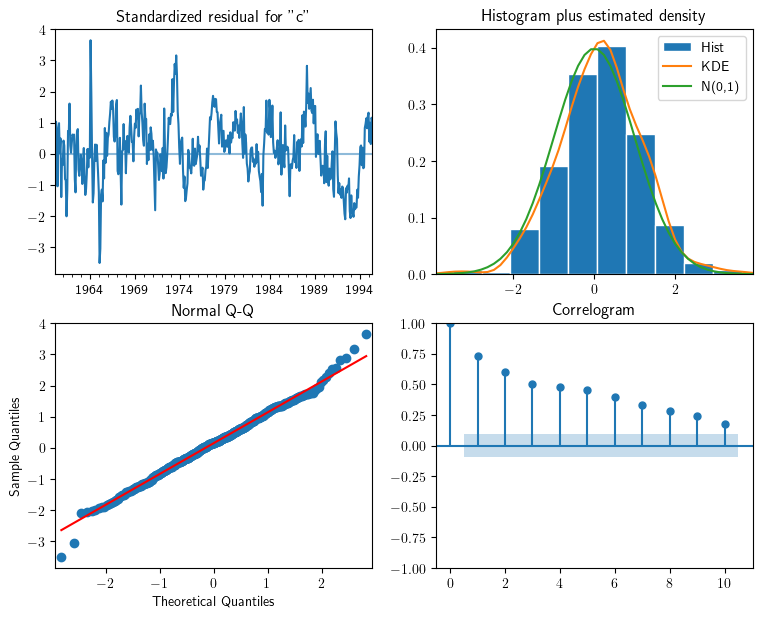

In [13]:
model_fit.plot_diagnostics(figsize=(9,7));

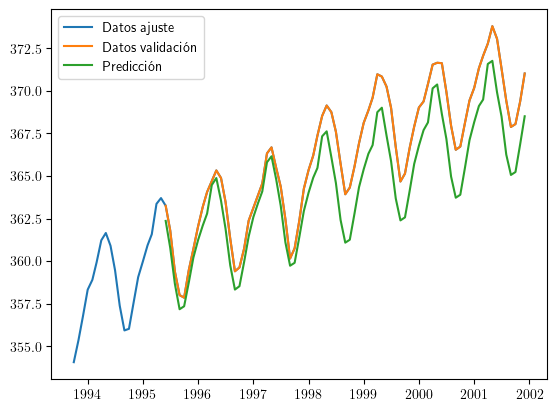

In [14]:
y_valid_fore = model_fit.forecast(steps=n_valid)
plt.plot(y[n_train-20:], label='Datos ajuste')
plt.plot(y_valid, label='Datos validación')
plt.plot(y_valid_fore, label='Predicción')
plt.legend(loc=2)
plt.show()


### Copyright 2020-2024 Facundo Batista y Manuel Carlevaro

Licencia CC BY-NC-SA 4.0

Para más info visitar: https://github.com/facundobatista/libro-pyciencia/

